# TWEETS PREPROCESSING AND SENTIMENT ANALYSIS 

Sentiment analysis is a process that automates mining of attitudes, views, opinions and
emotions from text, speech, tweets also through database sources through Natural Language
Processing (NLP). The purpose of Sentiment analysis is to classify opinions in text into
categories like "positive" or "negative" or "neutral". It's also defined as subjectivity analysis,
opinion mining, and appraisal extraction.

In [1]:
# import required libraries
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime 
import requests
import csv
import pprint
import requests

import pandas as pd                        
from pytrends.request import TrendReq
import tweepy
import json
import re
import os
import OpenBlender
from io import StringIO

import sweetviz 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
import string
import re
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from nltk.tokenize import TweetTokenizer


sns.set()

sns.set_style('whitegrid')

%matplotlib inline
pd.set_option('display.max_colwidth', 100)

# This actually makes autocomplete WAY faster ...
%config Completer.use_jedi = False

import plotly.express as px

from textblob import TextBlob

# nltk.download([
#     "names",
#     "stopwords",
#     "state_union",
#      "twitter_samples",
#    "movie_reviews",
#    "averaged_perceptron_tagger",
#    "vader_lexicon",
#    "punkt" ])

# NLP AND TWEETS SECTION

In [2]:
tweets_df=pd.read_excel("tweets_data2021_1000.xlsx")

feeds=pd.read_excel("feeds_lunar_crush.xlsx")

tweets_df=tweets_df[tweets_df["Date_Time"]<datetime.datetime(2021,7,7)]

tweets_df["Date_Time"]=tweets_df["Date_Time"].apply(lambda x:x.date() if isinstance(x,datetime.datetime) else "")

tweets_df["Date_Time"]=tweets_df["Date_Time"].astype("object")

In [3]:
tweets_df.head(5)

,Tweet Id,Text,Username,Date_Time
0,1344795468522515968,Happy new year cryptofam 🎊🎊🚀🎉🎉\nWishing you all the very best for 2021.\n\n#bitcoin $BTC #ethere...,CypherGh0st,2021-01-01
1,1344795459857096960,@cryptoworld202 It's to have Bitcoin because I don't have it.\nPlease send some to me.\nThanks.\...,job_focus,2021-01-01
2,1344795459215367936,Un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs Bitcoin ...,LaCryptoMonnai1,2021-01-01
3,1344795453402074880,My only hope for 2021 is that more people realize that #bitcoin can solve the wealth inequality ...,TheIRAFinancial,2021-01-01
4,1344795450000485888,#Investing 1017.4% in this optimal #crypto portfolio and -917.4% #cash in the past 24 hours woul...,CryptoWatchBot,2021-01-01


In [4]:
feeds.dtypes

lunar_id                        int64
asset_id                        int64
symbol                         object
name                           object
time                            int64
social_score                    int64
type                           object
id                             object
body                           object
sentiment                     float64
commented                     float64
likes                         float64
retweets                      float64
url                            object
display_name                   object
twitter_screen_name            object
profile_image                  object
title                          object
description                    object
image                          object
thumbnail                      object
average_sentiment             float64
publisher                      object
shares                        float64
subreddit                      object
link                           object
date        

In [5]:
feeds.sort_values(by="date",inplace=True)
feeds_btc=feeds[feeds["name"]=="Bitcoin"]
feeds_btc["time_date"]=feeds_btc["date"].apply(lambda x:x.date() if isinstance(x,datetime.datetime) else "")
feeds_btc=feeds_btc[["time_date","body","commented","likes","retweets","display_name","twitter_screen_name","shares","subreddit","link"]]
feeds_btc["time_date"]=feeds_btc["time_date"].astype("object")
feeds_btc.head(3)

<ipython-input-5-8a6a3b205c49>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feeds_btc["time_date"]=feeds_btc["date"].apply(lambda x:x.date() if isinstance(x,datetime.datetime) else "")


,time_date,body,commented,likes,retweets,display_name,twitter_screen_name,shares,subreddit,link
5108,2021-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN
6857,2021-01-02,I will give one follower who retweets this $100 #Bitcoin in 72 hours. Must follow @AnneliseBitAM...,720.0,1850.0,3056.0,IrishGirlCrypto #💚💚💚,IrishGirlCrypt1,NaN,NaN,NaN
5826,2021-01-02,"Bitcoin price.\n\nOne year ago: $7,200\n\nThree months ago: $10,800\n\nTwo months ago: $13,500\n...",129.0,5066.0,1045.0,The Spectator Index,spectatorindex,NaN,NaN,NaN


In [6]:
feeds_btc=feeds_btc[["time_date","twitter_screen_name","body"]]
feeds_btc
tweets_df=tweets_df[["Date_Time","Username","Text"]]
tweets_df.columns=["time_date","twitter_screen_name","body"]

In [7]:
tweets_df.head(4)

,time_date,twitter_screen_name,body
0,2021-01-01,CypherGh0st,Happy new year cryptofam 🎊🎊🚀🎉🎉\nWishing you all the very best for 2021.\n\n#bitcoin $BTC #ethere...
1,2021-01-01,job_focus,@cryptoworld202 It's to have Bitcoin because I don't have it.\nPlease send some to me.\nThanks.\...
2,2021-01-01,LaCryptoMonnai1,Un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs Bitcoin ...
3,2021-01-01,TheIRAFinancial,My only hope for 2021 is that more people realize that #bitcoin can solve the wealth inequality ...


In [8]:
total_tweets_df=pd.concat([tweets_df,feeds_btc])
total_tweets_df=total_tweets_df.reset_index(drop=True)

In [9]:
total_tweets_df["time_date"]=total_tweets_df["time_date"].astype("datetime64[ns]")
total_tweets_df.head()

,time_date,twitter_screen_name,body
0,2021-01-01,CypherGh0st,Happy new year cryptofam 🎊🎊🚀🎉🎉\nWishing you all the very best for 2021.\n\n#bitcoin $BTC #ethere...
1,2021-01-01,job_focus,@cryptoworld202 It's to have Bitcoin because I don't have it.\nPlease send some to me.\nThanks.\...
2,2021-01-01,LaCryptoMonnai1,Un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs Bitcoin ...
3,2021-01-01,TheIRAFinancial,My only hope for 2021 is that more people realize that #bitcoin can solve the wealth inequality ...
4,2021-01-01,CryptoWatchBot,#Investing 1017.4% in this optimal #crypto portfolio and -917.4% #cash in the past 24 hours woul...


# checking missing values

In [10]:
total_tweets_df.head()

,time_date,twitter_screen_name,body
0,2021-01-01,CypherGh0st,Happy new year cryptofam 🎊🎊🚀🎉🎉\nWishing you all the very best for 2021.\n\n#bitcoin $BTC #ethere...
1,2021-01-01,job_focus,@cryptoworld202 It's to have Bitcoin because I don't have it.\nPlease send some to me.\nThanks.\...
2,2021-01-01,LaCryptoMonnai1,Un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs Bitcoin ...
3,2021-01-01,TheIRAFinancial,My only hope for 2021 is that more people realize that #bitcoin can solve the wealth inequality ...
4,2021-01-01,CryptoWatchBot,#Investing 1017.4% in this optimal #crypto portfolio and -917.4% #cash in the past 24 hours woul...


In [11]:
total_tweets_df.dropna(inplace=True)

In [12]:

total_tweets_df.isnull().sum()

time_date              0
twitter_screen_name    0
body                   0
dtype: int64

In [13]:
total_tweets_df.head()

,time_date,twitter_screen_name,body
0,2021-01-01,CypherGh0st,Happy new year cryptofam 🎊🎊🚀🎉🎉\nWishing you all the very best for 2021.\n\n#bitcoin $BTC #ethere...
1,2021-01-01,job_focus,@cryptoworld202 It's to have Bitcoin because I don't have it.\nPlease send some to me.\nThanks.\...
2,2021-01-01,LaCryptoMonnai1,Un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs Bitcoin ...
3,2021-01-01,TheIRAFinancial,My only hope for 2021 is that more people realize that #bitcoin can solve the wealth inequality ...
4,2021-01-01,CryptoWatchBot,#Investing 1017.4% in this optimal #crypto portfolio and -917.4% #cash in the past 24 hours woul...


In [14]:
total_tweets_df.dtypes

time_date              datetime64[ns]
twitter_screen_name            object
body                           object
dtype: object

# CLEANING OF TWEETS

In [15]:
# bitcoin_df["Target"]=bitcoin_df["Day_Pct%_Change"].apply(lambda x: 0 if x<0 else 1)

In [16]:
# bitcoin_df["Target"].value_counts()

In [17]:
# sns.countplot(bitcoin_df["Target"])

In [18]:
# tweet_All = " ".join(review for review in total_tweets_df.body )
# tweet_All

In [19]:
# plt.figure(figsize  = (30,30))
# wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)

# plt.imshow(wordcloud_ALL, interpolation='bilinear')
# plt.title('All Tweets', fontsize=30)

# DATA PREPROCESSING



# Most of the text data are cleaned by following below steps.

# Remove punctuations
# Tokenization - Converting a sentence into list of words
# Remove stopwords
# Lammetization/stemming - Tranforming any form of a word to its root word 

In [20]:
for h,i in enumerate(total_tweets_df.body):
    print(i)
    if(h>5):
        break

Happy new year cryptofam 🎊🎊🚀🎉🎉
Wishing you all the very best for 2021.

#bitcoin $BTC #ethereum $ETH #polkadot $DOT
@cryptoworld202 It's to have Bitcoin because I don't have it.
Please send some to me.
Thanks.

bc1qj52uy05drymh7s4gupxdzrqeclcdkttjumyut6 https://t.co/m6K73UeOJ1
Un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs Bitcoin - https://t.co/fDv2LZzWS2
My only hope for 2021 is that more people realize that #bitcoin can solve the wealth inequality gap in America. Imagine if more people bought Bitcoin at under $5K how many more first time home buyers we could have......
#Investing 1017.4% in this optimal #crypto portfolio and -917.4% #cash in the past 24 hours would have given you a 4.4% return rather than #Bitcoin's 0.6%, for the same level of #risk https://t.co/gmJKigkWIi
@spraggy Its because #Bitcoin is at all time highs, and so are people's bankrolls.
@KennethBosak @klever_io TPQUDDTB6xFfYdGoRanwLFyd8nCSffuV1B

@bitcoin_clara 
@bitcoinmaxp

In [21]:
#1.lower the words

total_tweets_df['tweet_text'] = total_tweets_df.body.str.lower()

for i in total_tweets_df.tweet_text:
    print(i)
    if(h>5):
         break

happy new year cryptofam 🎊🎊🚀🎉🎉
wishing you all the very best for 2021.

#bitcoin $btc #ethereum $eth #polkadot $dot


In [22]:
#2.URL LINKS removal

total_tweets_df.tweet_text = total_tweets_df.tweet_text.apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
total_tweets_df.tweet_text = total_tweets_df.tweet_text.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))

for h,i in enumerate(total_tweets_df.tweet_text):
    print(i)
    if(h>9):
         break

happy new year cryptofam 🎊🎊🚀🎉🎉
wishing you all the very best for 2021.

#bitcoin $btc #ethereum $eth #polkadot $dot
@cryptoworld202 it's to have bitcoin because i don't have it.
please send some to me.
thanks.

bc1qj52uy05drymh7s4gupxdzrqeclcdkttjumyut6 
un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs bitcoin - 
my only hope for 2021 is that more people realize that #bitcoin can solve the wealth inequality gap in america. imagine if more people bought bitcoin at under $5k how many more first time home buyers we could have......
#investing 1017.4% in this optimal #crypto portfolio and -917.4% #cash in the past 24 hours would have given you a 4.4% return rather than #bitcoin's 0.6%, for the same level of #risk 
@spraggy its because #bitcoin is at all time highs, and so are people's bankrolls.
@kennethbosak @klever_io tpquddtb6xffydgoranwlfyd8ncsffuv1b

@bitcoin_clara 
@bitcoinmaxpoint 
@shashshshjeremy 
since i didn’t get any #bitcoin from @cashapp

In [23]:
# Placeholders Some text cleaning was already done on the dataset which replaced some links with {link}
# and all the videos with [video].
# They don’t seem to be of any value when doing sentiment analysis so I will remove them with regex.


total_tweets_df.tweet_text = total_tweets_df.tweet_text.apply(lambda x: re.sub(r'{link}', '', x))
total_tweets_df.tweet_text = total_tweets_df.tweet_text.apply(lambda x: re.sub(r"\[video\]", '', x))

for h,i in enumerate(total_tweets_df.tweet_text):
    print(i)
    if(h>9):
         break

happy new year cryptofam 🎊🎊🚀🎉🎉
wishing you all the very best for 2021.

#bitcoin $btc #ethereum $eth #polkadot $dot
@cryptoworld202 it's to have bitcoin because i don't have it.
please send some to me.
thanks.

bc1qj52uy05drymh7s4gupxdzrqeclcdkttjumyut6 
un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs bitcoin - 
my only hope for 2021 is that more people realize that #bitcoin can solve the wealth inequality gap in america. imagine if more people bought bitcoin at under $5k how many more first time home buyers we could have......
#investing 1017.4% in this optimal #crypto portfolio and -917.4% #cash in the past 24 hours would have given you a 4.4% return rather than #bitcoin's 0.6%, for the same level of #risk 
@spraggy its because #bitcoin is at all time highs, and so are people's bankrolls.
@kennethbosak @klever_io tpquddtb6xffydgoranwlfyd8ncsffuv1b

@bitcoin_clara 
@bitcoinmaxpoint 
@shashshshjeremy 
since i didn’t get any #bitcoin from @cashapp

In [24]:
# HTML reference characters I don’t think these are of any value to the analysis so they also should be removed.

total_tweets_df.tweet_text = total_tweets_df.tweet_text.apply(lambda x: re.sub(r'&[a-z]+;', '', x))

for h,i in enumerate(total_tweets_df.tweet_text):
    print(i)
    if(h>9):
         break

happy new year cryptofam 🎊🎊🚀🎉🎉
wishing you all the very best for 2021.

#bitcoin $btc #ethereum $eth #polkadot $dot
@cryptoworld202 it's to have bitcoin because i don't have it.
please send some to me.
thanks.

bc1qj52uy05drymh7s4gupxdzrqeclcdkttjumyut6 
un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs bitcoin - 
my only hope for 2021 is that more people realize that #bitcoin can solve the wealth inequality gap in america. imagine if more people bought bitcoin at under $5k how many more first time home buyers we could have......
#investing 1017.4% in this optimal #crypto portfolio and -917.4% #cash in the past 24 hours would have given you a 4.4% return rather than #bitcoin's 0.6%, for the same level of #risk 
@spraggy its because #bitcoin is at all time highs, and so are people's bankrolls.
@kennethbosak @klever_io tpquddtb6xffydgoranwlfyd8ncsffuv1b

@bitcoin_clara 
@bitcoinmaxpoint 
@shashshshjeremy 
since i didn’t get any #bitcoin from @cashapp

In [25]:
# Non-Letter characters I decided to get rid of all the characters that
# weren’t letters, punctuation that is commonly used in emojis, 
# or hash marks. There were a few non-english characters in the tweets. 
# I didn’t think they would add to the analysis so I wanted to remove them.
# Numbers typically don’t add much if any information so I wanted to remove them.
# Punctuation that isn’t usually associated with an emoji needed to be removed too because it didn’t add anything.
# I did all this with one regex.


total_tweets_df.tweet_text = total_tweets_df.tweet_text.apply(lambda x: re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', x))

for h,i in enumerate(total_tweets_df.tweet_text):
    print(i)
    if(h>9):
         break

happy new year cryptofam 
wishing you all the very best for 

#bitcoin btc #ethereum eth #polkadot dot
cryptoworld it's to have bitcoin because i don't have it
please send some to me
thanks

bcqjuydrymhsgupxdzrqeclcdkttjumyut 
un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs bitcoin - 
my only hope for  is that more people realize that #bitcoin can solve the wealth inequality gap in america imagine if more people bought bitcoin at under k how many more first time home buyers we could have
#investing  in this optimal #crypto portfolio and - #cash in the past  hours would have given you a  return rather than #bitcoin's  for the same level of #risk 
spraggy its because #bitcoin is at all time highs and so are people's bankrolls
kennethbosak kleverio tpquddtbxffydgoranwlfydncsffuvb

bitcoinclara 
bitcoinmaxpoint 
shashshshjeremy 
since i didnt get any #bitcoin from cashapp i bought myself  worth im gonna bring in the new year with an investment to set

In [26]:
# Twitter handles Prior the text pre-processing stage, 
# I changed all the twitter handles to @mention in acknowledgement of the need for 
# protecting people’s privacy. Because this dataset has been public for years I wasn’t adding much protection, 
# but when creating new datasets, an attempt to anonymize the data should be made. Since I had already changed them all to
# @mention it was easier to remove all of them; again because they added little information.

total_tweets_df.tweet_text = total_tweets_df.tweet_text.apply(lambda x: re.sub(r'@mention', '', x))


for h,i in enumerate(total_tweets_df.tweet_text):
    print(i)
    if(h>9):
         break

happy new year cryptofam 
wishing you all the very best for 

#bitcoin btc #ethereum eth #polkadot dot
cryptoworld it's to have bitcoin because i don't have it
please send some to me
thanks

bcqjuydrymhsgupxdzrqeclcdkttjumyut 
un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs bitcoin - 
my only hope for  is that more people realize that #bitcoin can solve the wealth inequality gap in america imagine if more people bought bitcoin at under k how many more first time home buyers we could have
#investing  in this optimal #crypto portfolio and - #cash in the past  hours would have given you a  return rather than #bitcoin's  for the same level of #risk 
spraggy its because #bitcoin is at all time highs and so are people's bankrolls
kennethbosak kleverio tpquddtbxffydgoranwlfydncsffuvb

bitcoinclara 
bitcoinmaxpoint 
shashshshjeremy 
since i didnt get any #bitcoin from cashapp i bought myself  worth im gonna bring in the new year with an investment to set

In [27]:
#removig non -english language words which are written in english alphabet like german or so 

# words = set(nltk.corpus.words.words())

# sent = "s que s que empresas como jnj o m llevan ms de  aos incrementando su dividendo por eso #yoinviertoenbolsa"

# " ".join(w for w in nltk.wordpunct_tokenize(sent) \

#          if w.lower() in words or not w.isalpha())



In [28]:
# Remove punctuations¶


def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

total_tweets_df.tweet_text = total_tweets_df.tweet_text.apply(lambda x: remove_punct(x))

for h,i in enumerate(total_tweets_df.tweet_text):
    print(i)
    if(h>5):
         break


happy new year cryptofam 
wishing you all the very best for 

bitcoin btc ethereum eth polkadot dot
cryptoworld its to have bitcoin because i dont have it
please send some to me
thanks

bcqjuydrymhsgupxdzrqeclcdkttjumyut 
un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs bitcoin  
my only hope for  is that more people realize that bitcoin can solve the wealth inequality gap in america imagine if more people bought bitcoin at under k how many more first time home buyers we could have
investing  in this optimal crypto portfolio and  cash in the past  hours would have given you a  return rather than bitcoins  for the same level of risk 
spraggy its because bitcoin is at all time highs and so are peoples bankrolls
kennethbosak kleverio tpquddtbxffydgoranwlfydncsffuvb

bitcoinclara 
bitcoinmaxpoint 
shashshshjeremy 


In [29]:
# Tokenization

def tokenization(text):
    text = re.split('\W+', text)
    return text

total_tweets_df['Tweet_tokenized'] = total_tweets_df['tweet_text'].apply(lambda x: tokenization(x.lower()))
total_tweets_df.head()

,time_date,twitter_screen_name,body,tweet_text,Tweet_tokenized
0,2021-01-01,CypherGh0st,Happy new year cryptofam 🎊🎊🚀🎉🎉\nWishing you all the very best for 2021.\n\n#bitcoin $BTC #ethere...,happy new year cryptofam \nwishing you all the very best for \n\nbitcoin btc ethereum eth polkad...,"[happy, new, year, cryptofam, wishing, you, all, the, very, best, for, bitcoin, btc, ethereum, e..."
1,2021-01-01,job_focus,@cryptoworld202 It's to have Bitcoin because I don't have it.\nPlease send some to me.\nThanks.\...,cryptoworld its to have bitcoin because i dont have it\nplease send some to me\nthanks\n\nbcqjuy...,"[cryptoworld, its, to, have, bitcoin, because, i, dont, have, it, please, send, some, to, me, th..."
2,2021-01-01,LaCryptoMonnai1,Un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs Bitcoin ...,un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs bitcoin,"[un, concessionnaire, de, voitures, de, luxe, devient, un, terrain, de, jeu, pour, les, investis..."
3,2021-01-01,TheIRAFinancial,My only hope for 2021 is that more people realize that #bitcoin can solve the wealth inequality ...,my only hope for is that more people realize that bitcoin can solve the wealth inequality gap i...,"[my, only, hope, for, is, that, more, people, realize, that, bitcoin, can, solve, the, wealth, i..."
4,2021-01-01,CryptoWatchBot,#Investing 1017.4% in this optimal #crypto portfolio and -917.4% #cash in the past 24 hours woul...,investing in this optimal crypto portfolio and cash in the past hours would have given you a ...,"[investing, in, this, optimal, crypto, portfolio, and, cash, in, the, past, hours, would, have, ..."


In [30]:
# Remove stopwords

stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
total_tweets_df['Tweet_nonstop'] = total_tweets_df['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))

total_tweets_df.head(4)

,time_date,twitter_screen_name,body,tweet_text,Tweet_tokenized,Tweet_nonstop
0,2021-01-01,CypherGh0st,Happy new year cryptofam 🎊🎊🚀🎉🎉\nWishing you all the very best for 2021.\n\n#bitcoin $BTC #ethere...,happy new year cryptofam \nwishing you all the very best for \n\nbitcoin btc ethereum eth polkad...,"[happy, new, year, cryptofam, wishing, you, all, the, very, best, for, bitcoin, btc, ethereum, e...","[happy, new, year, cryptofam, wishing, best, bitcoin, btc, ethereum, eth, polkadot, dot]"
1,2021-01-01,job_focus,@cryptoworld202 It's to have Bitcoin because I don't have it.\nPlease send some to me.\nThanks.\...,cryptoworld its to have bitcoin because i dont have it\nplease send some to me\nthanks\n\nbcqjuy...,"[cryptoworld, its, to, have, bitcoin, because, i, dont, have, it, please, send, some, to, me, th...","[cryptoworld, bitcoin, dont, please, send, thanks, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]"
2,2021-01-01,LaCryptoMonnai1,Un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs Bitcoin ...,un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs bitcoin,"[un, concessionnaire, de, voitures, de, luxe, devient, un, terrain, de, jeu, pour, les, investis...","[un, concessionnaire, de, voitures, de, luxe, devient, un, terrain, de, jeu, pour, les, investis..."
3,2021-01-01,TheIRAFinancial,My only hope for 2021 is that more people realize that #bitcoin can solve the wealth inequality ...,my only hope for is that more people realize that bitcoin can solve the wealth inequality gap i...,"[my, only, hope, for, is, that, more, people, realize, that, bitcoin, can, solve, the, wealth, i...","[hope, people, realize, bitcoin, solve, wealth, inequality, gap, america, imagine, people, bough..."


In [31]:
# Stemming and Lammitization¶

ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

total_tweets_df['Tweet_stemmed'] = total_tweets_df['Tweet_nonstop'].apply(lambda x: stemming(x))

total_tweets_df.head(4)

,time_date,twitter_screen_name,body,tweet_text,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed
0,2021-01-01,CypherGh0st,Happy new year cryptofam 🎊🎊🚀🎉🎉\nWishing you all the very best for 2021.\n\n#bitcoin $BTC #ethere...,happy new year cryptofam \nwishing you all the very best for \n\nbitcoin btc ethereum eth polkad...,"[happy, new, year, cryptofam, wishing, you, all, the, very, best, for, bitcoin, btc, ethereum, e...","[happy, new, year, cryptofam, wishing, best, bitcoin, btc, ethereum, eth, polkadot, dot]","[happi, new, year, cryptofam, wish, best, bitcoin, btc, ethereum, eth, polkadot, dot]"
1,2021-01-01,job_focus,@cryptoworld202 It's to have Bitcoin because I don't have it.\nPlease send some to me.\nThanks.\...,cryptoworld its to have bitcoin because i dont have it\nplease send some to me\nthanks\n\nbcqjuy...,"[cryptoworld, its, to, have, bitcoin, because, i, dont, have, it, please, send, some, to, me, th...","[cryptoworld, bitcoin, dont, please, send, thanks, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]","[cryptoworld, bitcoin, dont, pleas, send, thank, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]"
2,2021-01-01,LaCryptoMonnai1,Un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs Bitcoin ...,un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs bitcoin,"[un, concessionnaire, de, voitures, de, luxe, devient, un, terrain, de, jeu, pour, les, investis...","[un, concessionnaire, de, voitures, de, luxe, devient, un, terrain, de, jeu, pour, les, investis...","[un, concessionnair, de, voitur, de, lux, devient, un, terrain, de, jeu, pour, le, investisseur,..."
3,2021-01-01,TheIRAFinancial,My only hope for 2021 is that more people realize that #bitcoin can solve the wealth inequality ...,my only hope for is that more people realize that bitcoin can solve the wealth inequality gap i...,"[my, only, hope, for, is, that, more, people, realize, that, bitcoin, can, solve, the, wealth, i...","[hope, people, realize, bitcoin, solve, wealth, inequality, gap, america, imagine, people, bough...","[hope, peopl, realiz, bitcoin, solv, wealth, inequ, gap, america, imagin, peopl, bought, bitcoin..."


In [32]:
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

total_tweets_df['Tweet_lemmatized'] = total_tweets_df['Tweet_nonstop'].apply(lambda x: lemmatizer(x))

total_tweets_df.head(3)

,time_date,twitter_screen_name,body,tweet_text,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized
0,2021-01-01,CypherGh0st,Happy new year cryptofam 🎊🎊🚀🎉🎉\nWishing you all the very best for 2021.\n\n#bitcoin $BTC #ethere...,happy new year cryptofam \nwishing you all the very best for \n\nbitcoin btc ethereum eth polkad...,"[happy, new, year, cryptofam, wishing, you, all, the, very, best, for, bitcoin, btc, ethereum, e...","[happy, new, year, cryptofam, wishing, best, bitcoin, btc, ethereum, eth, polkadot, dot]","[happi, new, year, cryptofam, wish, best, bitcoin, btc, ethereum, eth, polkadot, dot]","[happy, new, year, cryptofam, wishing, best, bitcoin, btc, ethereum, eth, polkadot, dot]"
1,2021-01-01,job_focus,@cryptoworld202 It's to have Bitcoin because I don't have it.\nPlease send some to me.\nThanks.\...,cryptoworld its to have bitcoin because i dont have it\nplease send some to me\nthanks\n\nbcqjuy...,"[cryptoworld, its, to, have, bitcoin, because, i, dont, have, it, please, send, some, to, me, th...","[cryptoworld, bitcoin, dont, please, send, thanks, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]","[cryptoworld, bitcoin, dont, pleas, send, thank, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]","[cryptoworld, bitcoin, dont, please, send, thanks, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]"
2,2021-01-01,LaCryptoMonnai1,Un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs Bitcoin ...,un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs bitcoin,"[un, concessionnaire, de, voitures, de, luxe, devient, un, terrain, de, jeu, pour, les, investis...","[un, concessionnaire, de, voitures, de, luxe, devient, un, terrain, de, jeu, pour, les, investis...","[un, concessionnair, de, voitur, de, lux, devient, un, terrain, de, jeu, pour, le, investisseur,...","[un, concessionnaire, de, voitures, de, luxe, devient, un, terrain, de, jeu, pour, le, investiss..."


In [33]:
total_tweets_df.head(4)

,time_date,twitter_screen_name,body,tweet_text,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized
0,2021-01-01,CypherGh0st,Happy new year cryptofam 🎊🎊🚀🎉🎉\nWishing you all the very best for 2021.\n\n#bitcoin $BTC #ethere...,happy new year cryptofam \nwishing you all the very best for \n\nbitcoin btc ethereum eth polkad...,"[happy, new, year, cryptofam, wishing, you, all, the, very, best, for, bitcoin, btc, ethereum, e...","[happy, new, year, cryptofam, wishing, best, bitcoin, btc, ethereum, eth, polkadot, dot]","[happi, new, year, cryptofam, wish, best, bitcoin, btc, ethereum, eth, polkadot, dot]","[happy, new, year, cryptofam, wishing, best, bitcoin, btc, ethereum, eth, polkadot, dot]"
1,2021-01-01,job_focus,@cryptoworld202 It's to have Bitcoin because I don't have it.\nPlease send some to me.\nThanks.\...,cryptoworld its to have bitcoin because i dont have it\nplease send some to me\nthanks\n\nbcqjuy...,"[cryptoworld, its, to, have, bitcoin, because, i, dont, have, it, please, send, some, to, me, th...","[cryptoworld, bitcoin, dont, please, send, thanks, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]","[cryptoworld, bitcoin, dont, pleas, send, thank, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]","[cryptoworld, bitcoin, dont, please, send, thanks, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]"
2,2021-01-01,LaCryptoMonnai1,Un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs Bitcoin ...,un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs bitcoin,"[un, concessionnaire, de, voitures, de, luxe, devient, un, terrain, de, jeu, pour, les, investis...","[un, concessionnaire, de, voitures, de, luxe, devient, un, terrain, de, jeu, pour, les, investis...","[un, concessionnair, de, voitur, de, lux, devient, un, terrain, de, jeu, pour, le, investisseur,...","[un, concessionnaire, de, voitures, de, luxe, devient, un, terrain, de, jeu, pour, le, investiss..."
3,2021-01-01,TheIRAFinancial,My only hope for 2021 is that more people realize that #bitcoin can solve the wealth inequality ...,my only hope for is that more people realize that bitcoin can solve the wealth inequality gap i...,"[my, only, hope, for, is, that, more, people, realize, that, bitcoin, can, solve, the, wealth, i...","[hope, people, realize, bitcoin, solve, wealth, inequality, gap, america, imagine, people, bough...","[hope, peopl, realiz, bitcoin, solv, wealth, inequ, gap, america, imagin, peopl, bought, bitcoin...","[hope, people, realize, bitcoin, solve, wealth, inequality, gap, america, imagine, people, bough..."


In [34]:
#removal of \n which are lines between the sentences 

total_tweets_df.tweet_text = total_tweets_df.tweet_text.apply(lambda x: re.sub(r"[\n]", '', x))

In [35]:
#checking of duplicates in the data of tweet_text and removing them if present 

print("Total duplicates availaible in 'tweet_text' variable : ",total_tweets_df.tweet_text.duplicated().sum() )
total_tweets_df[total_tweets_df["tweet_text"].duplicated()==True].head()


Total duplicates availaible in 'tweet_text' variable :  11220


,time_date,twitter_screen_name,body,tweet_text,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized
127,2021-01-01,michaelgraub,#Bitcoin https://t.co/hHkchSwMtF,bitcoin,"[bitcoin, ]","[bitcoin, ]","[bitcoin, ]","[bitcoin, ]"
147,2021-01-01,DX5L4RRR,#Bitcoin \n2013年が上げ幅最高かと思ってましたが2010年でしたか。\nでもその年に全力ではなかなか行けないすｗ,bitcoin,"[bitcoin, ]","[bitcoin, ]","[bitcoin, ]","[bitcoin, ]"
188,2021-01-01,CryptoGent2,"The government wants to track every financial transaction you make, including #Bitcoin and other...",the government wants to track every financial transaction you make including bitcoin and other c...,"[the, government, wants, to, track, every, financial, transaction, you, make, including, bitcoin...","[government, wants, track, every, financial, transaction, make, including, bitcoin, crytpocurren...","[govern, want, track, everi, financi, transact, make, includ, bitcoin, crytpocurr, tell, stop, f...","[government, want, track, every, financial, transaction, make, including, bitcoin, crytpocurrenc..."
232,2021-01-01,wiseagent_apo,@bitcoin_qr #Bitcoin,bitcoinqr bitcoin,"[bitcoinqr, bitcoin]","[bitcoinqr, bitcoin]","[bitcoinqr, bitcoin]","[bitcoinqr, bitcoin]"
308,2021-01-01,BlockWatcher,"Fri Jan 1 00:48:22 2021 (7:11)\nUSD : 28,917.13\nWght: 0.0\nBlk#: 663,911\nSize: 1,122.5\nTxs :...",fri jan usd wght blk size txs pool mbbitcoin,"[fri, jan, usd, wght, blk, size, txs, pool, mb, bitcoin]","[fri, jan, usd, wght, blk, size, txs, pool, mb, bitcoin]","[fri, jan, usd, wght, blk, size, tx, pool, mb, bitcoin]","[fri, jan, usd, wght, blk, size, tx, pool, mb, bitcoin]"


In [36]:
#seeing the tweets which are duplicates there are 11215 tweets are there which are duplicates 

for i in total_tweets_df[total_tweets_df["tweet_text"].duplicated()==True]["tweet_text"]:
    print(i)
    break
    

bitcoin 


In [37]:
#there are about 11k rows which are same so we will remove this or drop the duplicates 

total_tweets_df =  total_tweets_df.drop_duplicates(subset=["tweet_text"],keep="first")

total_tweets_df.head()


,time_date,twitter_screen_name,body,tweet_text,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized
0,2021-01-01,CypherGh0st,Happy new year cryptofam 🎊🎊🚀🎉🎉\nWishing you all the very best for 2021.\n\n#bitcoin $BTC #ethere...,happy new year cryptofam wishing you all the very best for bitcoin btc ethereum eth polkadot dot,"[happy, new, year, cryptofam, wishing, you, all, the, very, best, for, bitcoin, btc, ethereum, e...","[happy, new, year, cryptofam, wishing, best, bitcoin, btc, ethereum, eth, polkadot, dot]","[happi, new, year, cryptofam, wish, best, bitcoin, btc, ethereum, eth, polkadot, dot]","[happy, new, year, cryptofam, wishing, best, bitcoin, btc, ethereum, eth, polkadot, dot]"
1,2021-01-01,job_focus,@cryptoworld202 It's to have Bitcoin because I don't have it.\nPlease send some to me.\nThanks.\...,cryptoworld its to have bitcoin because i dont have itplease send some to methanksbcqjuydrymhsgu...,"[cryptoworld, its, to, have, bitcoin, because, i, dont, have, it, please, send, some, to, me, th...","[cryptoworld, bitcoin, dont, please, send, thanks, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]","[cryptoworld, bitcoin, dont, pleas, send, thank, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]","[cryptoworld, bitcoin, dont, please, send, thanks, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]"
2,2021-01-01,LaCryptoMonnai1,Un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs Bitcoin ...,un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs bitcoin,"[un, concessionnaire, de, voitures, de, luxe, devient, un, terrain, de, jeu, pour, les, investis...","[un, concessionnaire, de, voitures, de, luxe, devient, un, terrain, de, jeu, pour, les, investis...","[un, concessionnair, de, voitur, de, lux, devient, un, terrain, de, jeu, pour, le, investisseur,...","[un, concessionnaire, de, voitures, de, luxe, devient, un, terrain, de, jeu, pour, le, investiss..."
3,2021-01-01,TheIRAFinancial,My only hope for 2021 is that more people realize that #bitcoin can solve the wealth inequality ...,my only hope for is that more people realize that bitcoin can solve the wealth inequality gap i...,"[my, only, hope, for, is, that, more, people, realize, that, bitcoin, can, solve, the, wealth, i...","[hope, people, realize, bitcoin, solve, wealth, inequality, gap, america, imagine, people, bough...","[hope, peopl, realiz, bitcoin, solv, wealth, inequ, gap, america, imagin, peopl, bought, bitcoin...","[hope, people, realize, bitcoin, solve, wealth, inequality, gap, america, imagine, people, bough..."
4,2021-01-01,CryptoWatchBot,#Investing 1017.4% in this optimal #crypto portfolio and -917.4% #cash in the past 24 hours woul...,investing in this optimal crypto portfolio and cash in the past hours would have given you a ...,"[investing, in, this, optimal, crypto, portfolio, and, cash, in, the, past, hours, would, have, ...","[investing, optimal, crypto, portfolio, cash, past, hours, would, given, return, rather, bitcoin...","[invest, optim, crypto, portfolio, cash, past, hour, would, given, return, rather, bitcoin, leve...","[investing, optimal, crypto, portfolio, cash, past, hour, would, given, return, rather, bitcoins..."


In [38]:
total_tweets_df.tweet_text.duplicated().sum()

0

In [39]:

tweet_All = " ".join(review for review in total_tweets_df.tweet_text )

# tweet_All



Text(0.5, 1.0, 'All Tweets')

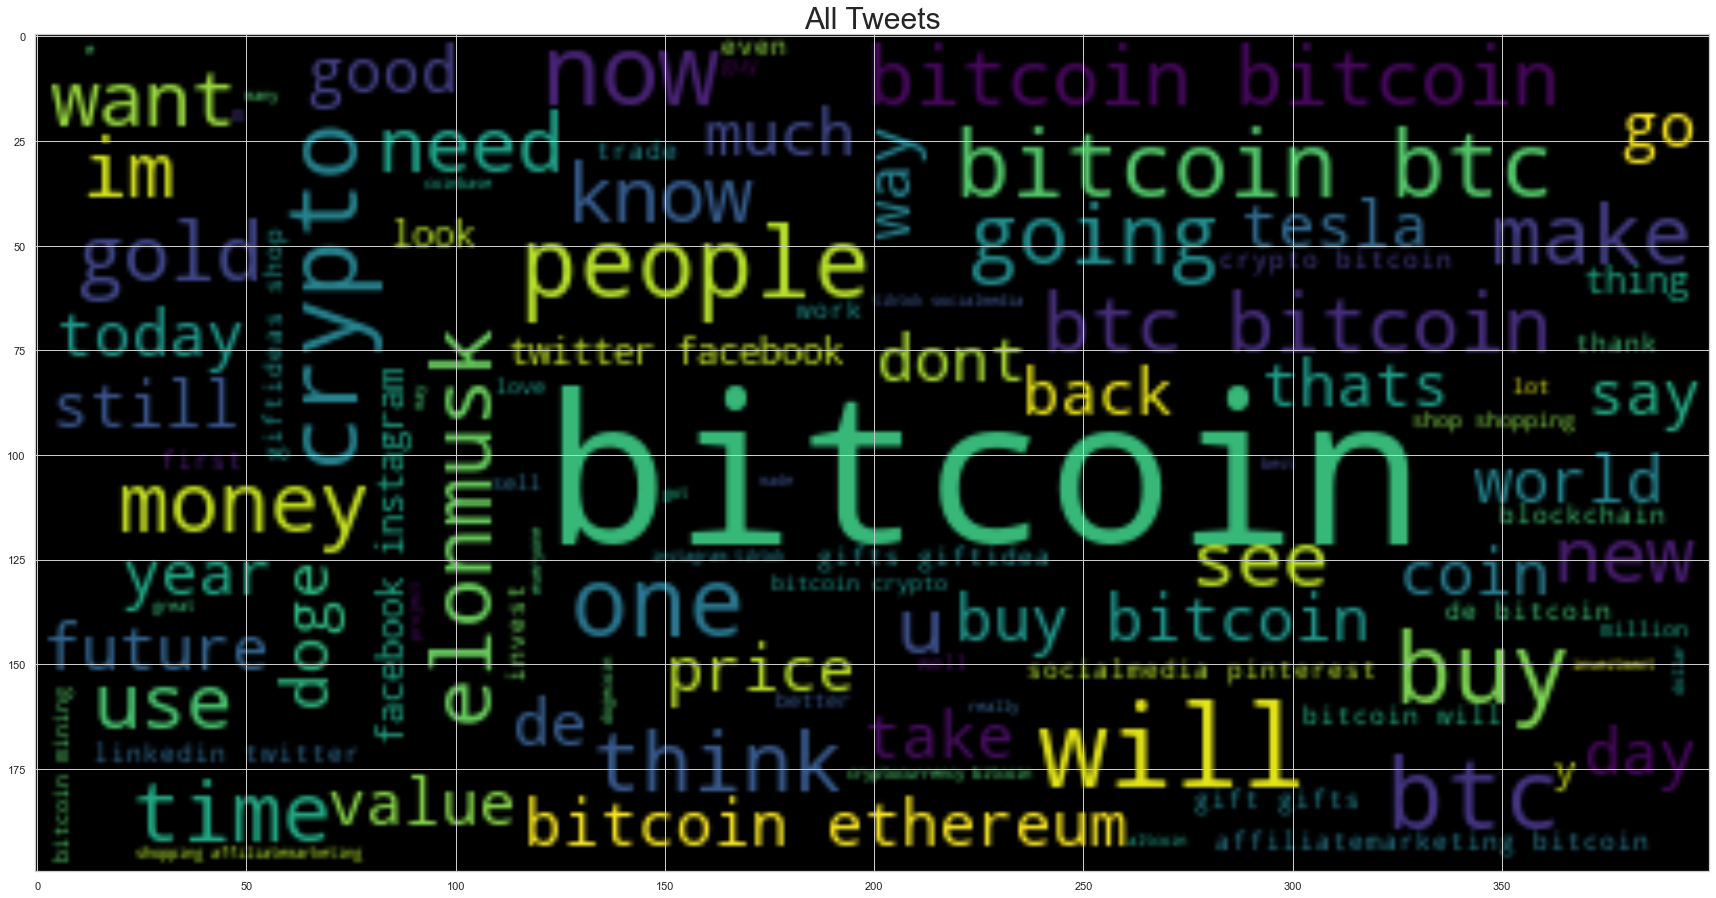

In [40]:
plt.figure(figsize  = (30,30))
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(tweet_All)

plt.imshow(wordcloud_ALL, interpolation='bilinear')
plt.title('All Tweets', fontsize=30)

In [41]:
total_tweets_df = total_tweets_df[total_tweets_df["tweet_text"]!=""]
total_tweets_df = total_tweets_df[total_tweets_df["tweet_text"]!=" "]

In [42]:
total_tweets_df.head(2)

,time_date,twitter_screen_name,body,tweet_text,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized
0,2021-01-01,CypherGh0st,Happy new year cryptofam 🎊🎊🚀🎉🎉\nWishing you all the very best for 2021.\n\n#bitcoin $BTC #ethere...,happy new year cryptofam wishing you all the very best for bitcoin btc ethereum eth polkadot dot,"[happy, new, year, cryptofam, wishing, you, all, the, very, best, for, bitcoin, btc, ethereum, e...","[happy, new, year, cryptofam, wishing, best, bitcoin, btc, ethereum, eth, polkadot, dot]","[happi, new, year, cryptofam, wish, best, bitcoin, btc, ethereum, eth, polkadot, dot]","[happy, new, year, cryptofam, wishing, best, bitcoin, btc, ethereum, eth, polkadot, dot]"
1,2021-01-01,job_focus,@cryptoworld202 It's to have Bitcoin because I don't have it.\nPlease send some to me.\nThanks.\...,cryptoworld its to have bitcoin because i dont have itplease send some to methanksbcqjuydrymhsgu...,"[cryptoworld, its, to, have, bitcoin, because, i, dont, have, it, please, send, some, to, me, th...","[cryptoworld, bitcoin, dont, please, send, thanks, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]","[cryptoworld, bitcoin, dont, pleas, send, thank, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]","[cryptoworld, bitcoin, dont, please, send, thanks, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]"


In [43]:
# total_tweets_df.to_excel("finding_vader_score_for_tweets.xlsx",index=False)

# #SENTIMENT ANALYZING OF CLEANED TWEETS ON 





In [44]:
# create a function to get subjectivity
def getSubjectivity(twt):
    return TextBlob(twt).sentiment.subjectivity

# create a function to get the polarity
def getPolarity(twt):
    return TextBlob(twt).sentiment.polarity

# create two new columns called "Subjectivity" & "Polarity"
total_tweets_df['subjectivity'] = total_tweets_df['tweet_text'].apply(getSubjectivity)
total_tweets_df['polarity'] = total_tweets_df['tweet_text'].apply(getPolarity)
total_tweets_df.head(2)

,time_date,twitter_screen_name,body,tweet_text,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized,subjectivity,polarity
0,2021-01-01,CypherGh0st,Happy new year cryptofam 🎊🎊🚀🎉🎉\nWishing you all the very best for 2021.\n\n#bitcoin $BTC #ethere...,happy new year cryptofam wishing you all the very best for bitcoin btc ethereum eth polkadot dot,"[happy, new, year, cryptofam, wishing, you, all, the, very, best, for, bitcoin, btc, ethereum, e...","[happy, new, year, cryptofam, wishing, best, bitcoin, btc, ethereum, eth, polkadot, dot]","[happi, new, year, cryptofam, wish, best, bitcoin, btc, ethereum, eth, polkadot, dot]","[happy, new, year, cryptofam, wishing, best, bitcoin, btc, ethereum, eth, polkadot, dot]",0.614848,0.645455
1,2021-01-01,job_focus,@cryptoworld202 It's to have Bitcoin because I don't have it.\nPlease send some to me.\nThanks.\...,cryptoworld its to have bitcoin because i dont have itplease send some to methanksbcqjuydrymhsgu...,"[cryptoworld, its, to, have, bitcoin, because, i, dont, have, it, please, send, some, to, me, th...","[cryptoworld, bitcoin, dont, please, send, thanks, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]","[cryptoworld, bitcoin, dont, pleas, send, thank, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]","[cryptoworld, bitcoin, dont, please, send, thanks, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]",0.000000,0.000000


In [45]:
def getSentiment(score):
    if score < 0:
        return "negative"
    elif score == 0:
        return "neutral"
    else:
        return "positive"
    
    
    
# create a column to store the text sentiment
total_tweets_df['sentiment'] = total_tweets_df['polarity'].apply(getSentiment)

# show the data
total_tweets_df.head()

,time_date,twitter_screen_name,body,tweet_text,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized,subjectivity,polarity,sentiment
0,2021-01-01,CypherGh0st,Happy new year cryptofam 🎊🎊🚀🎉🎉\nWishing you all the very best for 2021.\n\n#bitcoin $BTC #ethere...,happy new year cryptofam wishing you all the very best for bitcoin btc ethereum eth polkadot dot,"[happy, new, year, cryptofam, wishing, you, all, the, very, best, for, bitcoin, btc, ethereum, e...","[happy, new, year, cryptofam, wishing, best, bitcoin, btc, ethereum, eth, polkadot, dot]","[happi, new, year, cryptofam, wish, best, bitcoin, btc, ethereum, eth, polkadot, dot]","[happy, new, year, cryptofam, wishing, best, bitcoin, btc, ethereum, eth, polkadot, dot]",0.614848,0.645455,positive
1,2021-01-01,job_focus,@cryptoworld202 It's to have Bitcoin because I don't have it.\nPlease send some to me.\nThanks.\...,cryptoworld its to have bitcoin because i dont have itplease send some to methanksbcqjuydrymhsgu...,"[cryptoworld, its, to, have, bitcoin, because, i, dont, have, it, please, send, some, to, me, th...","[cryptoworld, bitcoin, dont, please, send, thanks, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]","[cryptoworld, bitcoin, dont, pleas, send, thank, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]","[cryptoworld, bitcoin, dont, please, send, thanks, bcqjuydrymhsgupxdzrqeclcdkttjumyut, ]",0.000000,0.000000,neutral
2,2021-01-01,LaCryptoMonnai1,Un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs Bitcoin ...,un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs bitcoin,"[un, concessionnaire, de, voitures, de, luxe, devient, un, terrain, de, jeu, pour, les, investis...","[un, concessionnaire, de, voitures, de, luxe, devient, un, terrain, de, jeu, pour, les, investis...","[un, concessionnair, de, voitur, de, lux, devient, un, terrain, de, jeu, pour, le, investisseur,...","[un, concessionnaire, de, voitures, de, luxe, devient, un, terrain, de, jeu, pour, le, investiss...",0.000000,0.000000,neutral
3,2021-01-01,TheIRAFinancial,My only hope for 2021 is that more people realize that #bitcoin can solve the wealth inequality ...,my only hope for is that more people realize that bitcoin can solve the wealth inequality gap i...,"[my, only, hope, for, is, that, more, people, realize, that, bitcoin, can, solve, the, wealth, i...","[hope, people, realize, bitcoin, solve, wealth, inequality, gap, america, imagine, people, bough...","[hope, peopl, realiz, bitcoin, solv, wealth, inequ, gap, america, imagin, peopl, bought, bitcoin...","[hope, people, realize, bitcoin, solve, wealth, inequality, gap, america, imagine, people, bough...",0.555556,0.375000,positive
4,2021-01-01,CryptoWatchBot,#Investing 1017.4% in this optimal #crypto portfolio and -917.4% #cash in the past 24 hours woul...,investing in this optimal crypto portfolio and cash in the past hours would have given you a ...,"[investing, in, this, optimal, crypto, portfolio, and, cash, in, the, past, hours, would, have, ...","[investing, optimal, crypto, portfolio, cash, past, hours, would, given, return, rather, bitcoin...","[invest, optim, crypto, portfolio, cash, past, hour, would, given, return, rather, bitcoin, leve...","[investing, optimal, crypto, portfolio, cash, past, hour, would, given, return, rather, bitcoins...",0.187500,-0.125000,negative


c:\users\mayur g\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

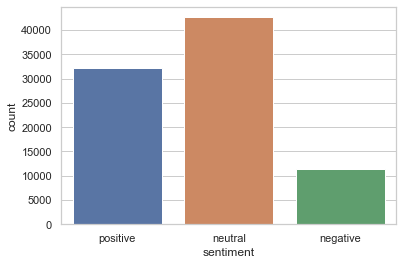

In [46]:
sns.countplot(total_tweets_df["sentiment"])

In [47]:
total_tweets_df["sentiment"].value_counts()

neutral     42663
positive    32186
negative    11339
Name: sentiment, dtype: int64

In [48]:
total_tweets_df["sentiment"].value_counts(normalize=True)*100

neutral     49.499930
positive    37.343946
negative    13.156124
Name: sentiment, dtype: float64

In [49]:
count=0
for i in total_tweets_df[total_tweets_df["sentiment"]=="negative"]["tweet_text"]:
    print(i)
    if(count>6):
        break
    count+=1

investing  in this optimal crypto portfolio and  cash in the past  hours would have given you a  return rather than bitcoins  for the same level of risk 
is vanilla extract pegged to bitcoin it is too expensive
dennisnagpal the sad part is all the bitcoin im down because i bought iota 
sakakmusdom cryptovice when i say physiologically driven i mean that it remains at the whims of the prevailing majority  that is always the uncertaintyhowever as churchill once described democracy as the worst form of government except all others  bitcoin could be similarly described
cashapp molecules  bitcoin crazy
peterschiff you call yourself that someone that looks at economics and gold especially but the only thing i see is you criticizing bitcoin you cant compare btc to other assets its like apples and pineapples anyways no more attention from my side unfollowed
cashapp the rules say enter through twitter or instagram  does it indeed mean or or could it mean andi want to enter both places but i don

In [50]:
count=0
for i in total_tweets_df[total_tweets_df["sentiment"]=="neutral"]["tweet_text"]:
    print(i)
    if(count>6):
        break
    count+=1

cryptoworld its to have bitcoin because i dont have itplease send some to methanksbcqjuydrymhsgupxdzrqeclcdkttjumyut 
un concessionnaire de voitures de luxe devient un terrain de jeu pour les investisseurs bitcoin  
spraggy its because bitcoin is at all time highs and so are peoples bankrolls
kennethbosak kleverio tpquddtbxffydgoranwlfydncsffuvbbitcoinclara bitcoinmaxpoint shashshshjeremy 
bitcoin is at  usd
conscripting buy bitcoin 
bitcoin price index  usd eur cny gbp rub 
bitcoin bitcoin bitcoin


In [51]:
total_tweets_df["polarity"].describe()

count    86188.000000
mean         0.083863
std          0.233523
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.175000
max          1.000000
Name: polarity, dtype: float64

In [52]:
total_tweets_df["subjectivity"].describe()

count    86188.000000
mean         0.283583
std          0.305504
min          0.000000
25%          0.000000
50%          0.200000
75%          0.500000
max          1.000000
Name: subjectivity, dtype: float64

# Master_data_Preparation : Combining tweets sentiments and daily bitcoin tradings 


In [53]:
ndf=total_tweets_df[["time_date","subjectivity","polarity"]].groupby(["time_date"]).mean()

ndf=ndf.reset_index()

ndf.head()

#daily tweets polarity 

,time_date,subjectivity,polarity
0,2021-01-01,0.308412,0.115455
1,2021-01-02,0.297433,0.086049
2,2021-01-03,0.275105,0.066315
3,2021-01-04,0.297309,0.102990
4,2021-01-05,0.279682,0.082361


In [54]:
#daily bitcoin trading data 


bitcoin_df = pd.read_excel("Bitcoin_data_crypto_label.xlsx")
bitcoin_df.head()

,Name,Symbol,Date,High,Low,Open,Close,market_billion_usd$,volume_billion_usd$,Day_Pct%_Change,Trend,Target
0,Bitcoin,BTC,2021-01-02,33155.11882,29091.18119,29376.45583,32127.26794,597,67.865421,9.372581,Bull run,1
1,Bitcoin,BTC,2021-01-03,34608.55674,32052.31708,32129.40736,32782.02447,609,78.665235,2.038009,Positive,1
2,Bitcoin,BTC,2021-01-04,33440.21857,28722.75527,32810.94764,31971.91352,594,81.163475,-2.471205,Negative,0
3,Bitcoin,BTC,2021-01-05,34437.59059,30221.18674,31977.04113,33992.42934,632,67.547325,6.319659,Among top gainers,1
4,Bitcoin,BTC,2021-01-06,36879.69857,33514.03374,34013.61453,36824.36441,685,75.289434,8.331076,Bull run,1


In [55]:
#since in bitcoin_df we have trading date ranges from 2nd january to 6th july so we will remove record of 1st january from 
#ndf dataframe to combine the data

ndf = ndf[(ndf["time_date"]!= datetime.datetime(2021,1,1))  ]
ndf = ndf.reset_index(drop=True)

ndf.head()

,time_date,subjectivity,polarity
0,2021-01-02,0.297433,0.086049
1,2021-01-03,0.275105,0.066315
2,2021-01-04,0.297309,0.102990
3,2021-01-05,0.279682,0.082361
4,2021-01-06,0.323917,0.087930


In [56]:
#combining both the values from ndf and bitcoin_df to create final data merging polarity and trading data 


bitcoin_master_df = pd.concat([bitcoin_df,ndf.drop("time_date",axis=1)],axis=1)
bitcoin_master_df.head(2)

,Name,Symbol,Date,High,Low,Open,Close,market_billion_usd$,volume_billion_usd$,Day_Pct%_Change,Trend,Target,subjectivity,polarity
0,Bitcoin,BTC,2021-01-02,33155.11882,29091.18119,29376.45583,32127.26794,597,67.865421,9.372581,Bull run,1,0.297433,0.086049
1,Bitcoin,BTC,2021-01-03,34608.55674,32052.31708,32129.40736,32782.02447,609,78.665235,2.038009,Positive,1,0.275105,0.066315
